In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, mean_squared_error, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.cuda import FloatTensor, LongTensor
from torch.utils.data.sampler import SubsetRandomSampler
from Features import feature_process
import category_encoders as ce
from early_stop import EarlyStopping
import math
import os

In [2]:
df_train = pd.read_excel('Dataset/train_dataset_hackathon_mkb_excel.xlsx', index_col=0)
target = df_train.TARGET
df_train = df_train.drop('TARGET', axis = 1)
answer = pd.read_csv('Dataset/answer_file.csv', index_col=0)
test = pd.read_csv('Dataset/test_file.csv', index_col=0)

### Формируем выборку для контроля

In [3]:
#формируем выборку для контроля
data_train, data_valid, data_target, target_valid = train_test_split ( 
    df_train, target, test_size = 0.2, random_state = 17)

### Обработка датафрейма

In [4]:
data_train = feature_process(data_train)

In [5]:
data_train.AGE.fillna(data_train.AGE.median(), inplace = True) # Заполняем пропущенные значения AGE медианой
app_nonull = list(filter(lambda x: (data_train[x].isin([0]).any() == False) and (data_train[x].dtypes != 'O') , data_train.columns))
app_nan =  list(filter(lambda x: (data_train[x].isna().any() == True) and (data_train[x].dtypes != 'O') , data_train.columns))
data_train[app_nan] = data_train[app_nan].fillna(0)
app_bool = list(filter(lambda x: len(data_train[x].unique()) == 2 , data_train.columns))
app_obj = list(filter(lambda x: data_train[x].dtypes == 'O', data_train.columns))
app_category = app_bool + app_obj + ['id_client', 'OKATO_REGIONCODE', 'OKATO_FED', 'OKTMO_CODE', 'OKTMO_FED']
app_num = list(filter(lambda x: x not in app_category, data_train.columns))
data_train[app_category] = data_train[app_category].astype(str)

### Удаление коррелирующих стобцов

In [6]:
threshold = 0.95
cm = data_train[app_num].corr()
df_not_correlated = ~(cm.mask(np.tril(np.ones([len(cm)]*2, dtype=bool))).abs() > threshold).any()
un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
data_train = data_train[list(un_corr_idx) + app_category]

### Замена максимальных значений (выбросов)

In [7]:
for col in un_corr_idx:
    median = data_train[col].median() # 55.84, 68.05
    std = data_train[col].std()
    outliers = (data_train[col]-median) > 3*std
    to_replace = list(data_train[col][outliers==True].values)
    data_train[col].replace(to_replace, value = (median+ 3*std), inplace = True)

<font size="4" face="Arial"><strong> Формируем выборку для кросс-валидации

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split ( 
    data_train, data_target, test_size = 0.22, random_state = 33)
X_train = X_train.reset_index(drop = True)
X_valid = X_valid.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_valid = y_valid.reset_index(drop = True)

<font size="4" face="Arial"><strong> Стандартизируем числовые значения

In [9]:
sc = StandardScaler()
app_num = un_corr_idx
scaler = sc.fit(X_train[app_num])
X_train[app_num] = pd.DataFrame(scaler.transform(X_train[app_num]), columns = app_num)
X_valid[app_num] = pd.DataFrame(scaler.transform(X_valid[app_num]), columns = app_num)

### Обработка тестовых данных

In [10]:
data_valid = feature_process(data_valid)
data_valid = data_valid.drop('cnt', axis = 1)
df_duplic_id = pd.DataFrame(df_train.id_client.value_counts()).reset_index().rename(columns={'index': 'id_client', 'id_client': 'cnt'})
data_valid = pd.merge(
                        data_valid,
                        df_duplic_id,
                        how="left",
                        on='id_client',
                        right_index=False,
                        validate='many_to_one'
                    )
data_valid[app_nan] = data_valid[app_nan].fillna(0)
data_valid[app_category] = data_valid[app_category].fillna('unknown')
data_valid[app_category] = data_valid[app_category].astype(str)
data_valid[app_num] = pd.DataFrame(scaler.transform(data_valid[app_num]), columns = app_num)
data_valid = data_valid[list(un_corr_idx) + app_category]

<font size="4" face="Arial"><strong> NN с целевым кодированием категориальных признаков

In [11]:
print(torch.cuda.device_count())
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

1


In [12]:
data_valid_nn = data_valid.copy()
X_train_nn = X_train.copy()
X_valid_nn = X_valid.copy()
y_train_nn = y_train.copy()
y_valid_nn = y_valid.copy()

<font size="4" face="Arial"><strong> Обработка категориальных признаков

In [13]:
traintargetEncoder = ce.TargetEncoder(cols=app_category, handle_unknown='value').fit(X_train[app_category], y_train)
X_train_nn[app_category] = traintargetEncoder.transform(X_train[app_category])
X_valid_nn[app_category] = traintargetEncoder.transform(X_valid[app_category])
data_valid_nn[app_category] = traintargetEncoder.transform(data_valid[app_category])
# data_valid_nn = data_valid.fillna(data_valid.median())

In [14]:
data_valid_nn = torch.cuda.FloatTensor(data_valid_nn.values)
X_train_nn = torch.cuda.FloatTensor(X_train_nn.values)
X_valid_nn = torch.cuda.FloatTensor(X_valid_nn.values)
y_train_nn = torch.cuda.FloatTensor(y_train_nn.values)
y_valid_nn = torch.cuda.FloatTensor(y_valid_nn.values)

In [37]:
class NN_model(nn.Module):
    def __init__(self, input):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Linear(input, 40),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.BatchNorm1d(40),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 1))
        
    def forward (self,  x): 
        return  self.layer_1(x)
    
nn_model = NN_model(X_train_nn.shape[1]).to(device)
nn_model

NN_model(
  (layer_1): Sequential(
    (0): Linear(in_features=95, out_features=40, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=40, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [38]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=3e-2)
torch.manual_seed(31)
epochs = 1000
patience = 20
es = EarlyStopping(mode='max', metric_name='ROC-AUC', patience = patience)

# Cтроим модель для тренировки 
for epoch in range(epochs):
    nn_model.train()
    y_logits = nn_model(X_train_nn).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
    # Считаем loss/roc_auc
    loss = loss_fn(y_logits, y_train_nn) 
    roc_auc = roc_auc_score(y_train_nn.cpu(), y_pred.cpu().detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Тестируем модель 
    nn_model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = nn_model(X_valid_nn).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_valid_nn)
        test_roc_auc = roc_auc_score(y_valid_nn.cpu(), test_pred.cpu().detach().numpy())
        es(test_roc_auc, nn_model)
        if es.early_stop:
            print('Early stopping reached. Stop training...')
            print(f"Epoch: {epoch-patience} | ROC-AUC: {es.best_score:.3f}% ")
            break
    # Print out what's happening every 20 epochs
    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Train ROC-AUC: {roc_auc:.2f}% | Test loss: {test_loss:.5f}, Test ROC-AUC: {test_roc_auc:.4f}")

Epoch: 0 | Loss: 0.70076, Train ROC-AUC: 0.51% | Test loss: 0.63991, Test ROC-AUC: 0.7440
Epoch: 20 | Loss: 0.23723, Train ROC-AUC: 0.89% | Test loss: 0.26259, Test ROC-AUC: 0.8707
Epoch: 40 | Loss: 0.21002, Train ROC-AUC: 0.90% | Test loss: 0.25071, Test ROC-AUC: 0.8757
Epoch: 60 | Loss: 0.20145, Train ROC-AUC: 0.90% | Test loss: 0.24685, Test ROC-AUC: 0.8758
Early stopping reached. Stop training...
Epoch: 47 | ROC-AUC: 0.886% 


In [39]:
nn_model.load_state_dict(es.best_weigts) #загружаем лучшие параметры NN

<All keys matched successfully>

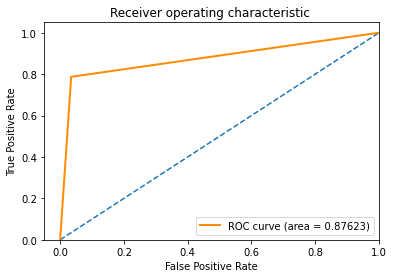

CPU times: total: 93.8 ms
Wall time: 93.1 ms


In [40]:
%%time
predict_nn =  torch.round(torch.sigmoid(nn_model(data_valid_nn).squeeze())).cpu().detach().numpy()
auc_score = roc_auc_score(target_valid, predict_nn)
fpr, tpr, thresholds = roc_curve(target_valid, predict_nn)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, color="darkorange",
    lw=2,
    label="ROC curve (area = %0.5f)" % auc_score,
)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

In [41]:
auc_score

0.8762253242991296

In [42]:
predict_nn_1 =  torch.round(torch.sigmoid(nn_model(X_train_nn).squeeze())).cpu().detach().numpy()
answer['NN_cat_target'] = predict_nn_1

### NN с эмбеддингом категориальных признаков

In [44]:
device = torch.device("cuda:0")

In [45]:
data_valid_emb = data_valid.copy()
X_train_emb = X_train.copy()
X_valid_emb = X_valid.copy()
y_train_emb = y_train.copy()
y_valid_emb = y_valid.copy()

In [46]:
data = pd.concat([X_train_emb[app_category], X_valid_emb[app_category], data_valid_emb[app_category]])

In [47]:
oridinal_Encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1).fit(data)
X_train_emb[app_category] = oridinal_Encoder.transform(X_train_emb[app_category]).astype('int32')
X_valid_emb[app_category] = oridinal_Encoder.transform(X_valid_emb[app_category]).astype('int32')
data_valid_emb[app_category] = oridinal_Encoder.transform(data_valid_emb[app_category]).astype('int32')

In [48]:
data_valid_cat =  torch.IntTensor(data_valid_emb[app_category].values).to(device)
data_valid_num =  torch.FloatTensor(data_valid[app_num].values).to(device)
X_train_cat =  torch.IntTensor(X_train_emb[app_category].values).to(device)
X_train_num =  torch.FloatTensor(X_train[app_num].values).to(device)
X_valid_cat =  torch.LongTensor(X_valid_emb[app_category].values).to(device)
X_valid_num =  torch.FloatTensor(X_valid_emb[app_num].values).to(device)
y_train_emb =  torch.FloatTensor(y_train.values).to(device)
y_valid_emb =  torch.FloatTensor(y_valid.values).to(device)

In [49]:
embedding_projection = {i: (data[i].nunique()+1, \
                            round(min(600, 1 + 1.6 * data[i].nunique() ** 0.56))) for i in app_category}

In [60]:
class Emb_RNN(nn.Module):
    # Аргументы:
#         embedding_projection: список размеров словаря эмбеддинга
    def __init__(self, embedding_projection, n_cont, drops, szs, emb_drop = 0.4,  use_bn = True):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in list(embedding_projection.values())])
        n_emb = sum(e.embedding_dim for e in self.embeddings) # длина всех комбинируемых эмбеддингов
        for emb in self.embeddings: emb_init(emb)
        self.n_emb, self.n_cont = n_emb, n_cont
        szs = [n_emb+n_cont] + szs
        self.emb_drop = nn.Dropout(emb_drop)

        self.gru = nn.GRU(input_size=self.n_emb,
                             hidden_size=128, bidirectional=True)
        
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.lins = nn.ModuleList([nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: nn.init.kaiming_normal_(o.weight.data) # инициализируем входные веса
        self.outp = nn.Linear(szs[-1], 1)
        nn.init.kaiming_normal_(self.outp.weight.data)
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn = use_bn

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:, i]) for i,e in enumerate(self.embeddings)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1)
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        return x
    
def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)

emb_model = Emb_RNN(embedding_projection, len(app_num), drops = [0.1,0.2], szs = [40, 20], use_bn = True).to(device)
emb_model

Emb_RNN(
  (embeddings): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(17, 9)
    (4): Embedding(369, 45)
    (5): Embedding(7, 5)
    (6): Embedding(7, 5)
    (7): Embedding(6, 5)
    (8): Embedding(14, 8)
    (9): Embedding(206, 33)
    (10): Embedding(427, 48)
    (11): Embedding(4, 4)
    (12): Embedding(6, 5)
    (13): Embedding(8923, 262)
    (14): Embedding(85, 20)
    (15): Embedding(10, 6)
    (16): Embedding(1766, 106)
    (17): Embedding(10, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (gru): GRU(576, 128, bidirectional=True)
  (drops): ModuleList(
    (0): Dropout(p=0.1, inplace=False)
    (1): Dropout(p=0.2, inplace=False)
  )
  (lins): ModuleList(
    (0): Linear(in_features=653, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=20, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(20, ep

In [61]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(emb_model.parameters(), lr=3e-2)
epochs = 1000
patience = 40
es = EarlyStopping(mode='max', metric_name='ROC-AUC', patience = patience)

# Cтроим модель для тренировки 
for epoch in range(epochs):
    emb_model.train()
    y_logits = emb_model(X_train_cat, X_train_num).squeeze() 
    y_pred = torch.round(torch.sigmoid(y_logits))
  
    # Считаем ошибку
    loss = loss_fn(y_logits, y_train_emb) 
    roc_auc = roc_auc_score(y_train_emb.cpu(), y_pred.cpu().detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Тестируем модель 
    emb_model.eval()
    with torch.inference_mode():
        test_logits = emb_model(X_valid_cat, X_valid_num).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_valid_emb)
        test_roc_auc = roc_auc_score(y_valid_emb.cpu(), test_pred.cpu().detach().numpy())
        es(test_roc_auc, emb_model)
        if es.early_stop:
            print('Early stopping reached. Stop training...')
            print(f"Epoch: {epoch-patience} | ROC-AUC: {es.best_score:.3f}% ")
            break

    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Train ROC-AUC: {roc_auc:.2f}% | Test loss: {test_loss:.5f}, Test ROC-AUC: {test_roc_auc:.4f}")

Epoch: 0 | Loss: 0.81798, Train ROC-AUC: 0.52% | Test loss: 0.56326, Test ROC-AUC: 0.6770
Epoch: 20 | Loss: 0.02408, Train ROC-AUC: 0.99% | Test loss: 0.54661, Test ROC-AUC: 0.8864
Epoch: 40 | Loss: 0.01702, Train ROC-AUC: 0.99% | Test loss: 0.37209, Test ROC-AUC: 0.8857
Early stopping reached. Stop training...
Epoch: 6 | ROC-AUC: 0.890% 


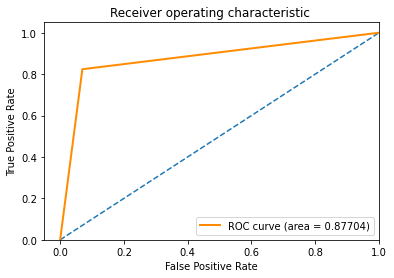

CPU times: total: 93.8 ms
Wall time: 102 ms


In [62]:
%%time
emb_model.load_state_dict(es.best_weigts) #загружаем лучшие параметры NN
predict_emb =  torch.round(torch.sigmoid(emb_model(data_valid_cat, data_valid_num).squeeze())).cpu().detach().numpy()
auc_score = roc_auc_score(target_valid, predict_emb)
fpr, tpr, thresholds = roc_curve(target_valid, predict_emb)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, color="darkorange",
    lw=2,
    label="ROC curve (area = %0.5f)" % auc_score,
)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()